In [1]:
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import pandas as pd 
from numpy import sort

In [2]:
# loaddataset 
dataset = pd.read_csv('diabetes.csv') 

In [3]:
dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [33]:
X = dataset.drop('Outcome', axis=1).values 
y = dataset.Outcome.values 

In [53]:
# set seed and split to train and test datasets 
seed = 11
test_size = 0.33 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,random_state=seed)

In [45]:
# fit model on training data
model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test 
predictions = model.predict(X_test)

In [46]:
# evaluate the models 
accuracy = accuracy_score(y_test, predictions) 
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 79.92%


[0.09296753 0.2369242  0.10471074 0.0848868  0.10554386 0.14981464
 0.09501134 0.13014093]


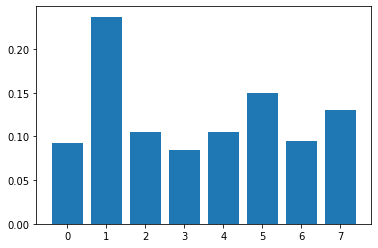

In [47]:
# feature importance
print(model.feature_importances_)
# plot
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

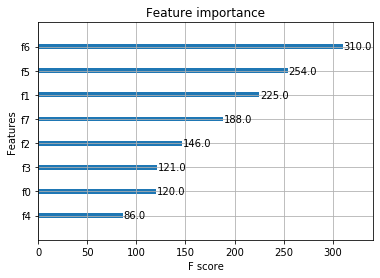

In [48]:
# plot feature importance
plot_importance(model)
plt.show()

In [54]:
accuracy_value = [] 
threshold_value = [] 
thresholds = sort(model.feature_importances_)
for thresh in thresholds: 
    # select features using threshold 
    selection = SelectFromModel(model, threshold = thresh, prefit=True) 
    select_X_train = selection.transform(X_train) 

    # train model 
    selection_model = XGBClassifier() 
    selection_model.fit(select_X_train, y_train) 

    #eval model 
    select_X_test = selection.transform(X_test) 
    predictions = selection_model.predict(select_X_test) 
    accuracy = accuracy_score(y_test, predictions) 
    threshold_value.append(select_X_train.shape[1]) 
    accuracy_value.append(accuracy)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1],accuracy*100.0))


Thresh=0.085, n=8, Accuracy: 74.80%
Thresh=0.093, n=7, Accuracy: 76.38%
Thresh=0.095, n=6, Accuracy: 76.38%
Thresh=0.105, n=5, Accuracy: 73.23%
Thresh=0.106, n=4, Accuracy: 74.02%
Thresh=0.130, n=3, Accuracy: 77.56%
Thresh=0.150, n=2, Accuracy: 71.26%
Thresh=0.237, n=1, Accuracy: 73.23%


In [55]:
def plot_threshold_vs_accuracy(threshold_values, accuracy_values):
    plt.plot(threshold_values, accuracy_values, marker='o', linestyle='-')
    plt.xlabel('Features')
    plt.ylabel('Accuracy')
    plt.title('Threshold vs. Accuracy')
    plt.grid(True)
    plt.show()

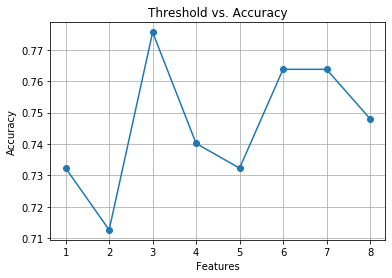

In [56]:
# Plot the threshold versus accuracy
plot_threshold_vs_accuracy(threshold_value, accuracy_value)

In [57]:
# early stopping with xgboost 
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)
# make predictions for test data
predictions = model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

[0]	validation_0-error:0.17899	validation_0-logloss:0.56785	validation_1-error:0.27953	validation_1-logloss:0.60720
[1]	validation_0-error:0.14786	validation_0-logloss:0.49181	validation_1-error:0.27165	validation_1-logloss:0.56171
[2]	validation_0-error:0.10895	validation_0-logloss:0.42989	validation_1-error:0.25984	validation_1-logloss:0.52669
[3]	validation_0-error:0.09533	validation_0-logloss:0.38381	validation_1-error:0.25591	validation_1-logloss:0.51372
[4]	validation_0-error:0.09728	validation_0-logloss:0.35061	validation_1-error:0.25591	validation_1-logloss:0.50175
[5]	validation_0-error:0.07198	validation_0-logloss:0.31914	validation_1-error:0.24016	validation_1-logloss:0.49618
[6]	validation_0-error:0.05642	validation_0-logloss:0.29530	validation_1-error:0.24016	validation_1-logloss:0.49222
[7]	validation_0-error:0.05253	validation_0-logloss:0.27715	validation_1-error:0.24016	validation_1-logloss:0.49175
[8]	validation_0-error:0.04669	validation_0-logloss:0.25933	validation_1

c:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


[43]	validation_0-error:0.00000	validation_0-logloss:0.07199	validation_1-error:0.24409	validation_1-logloss:0.57045
[44]	validation_0-error:0.00000	validation_0-logloss:0.06996	validation_1-error:0.24016	validation_1-logloss:0.57368
[45]	validation_0-error:0.00000	validation_0-logloss:0.06814	validation_1-error:0.23622	validation_1-logloss:0.57581
[46]	validation_0-error:0.00000	validation_0-logloss:0.06705	validation_1-error:0.23622	validation_1-logloss:0.57969
[47]	validation_0-error:0.00000	validation_0-logloss:0.06503	validation_1-error:0.24409	validation_1-logloss:0.58155
[48]	validation_0-error:0.00000	validation_0-logloss:0.06373	validation_1-error:0.25197	validation_1-logloss:0.58540
[49]	validation_0-error:0.00000	validation_0-logloss:0.06216	validation_1-error:0.24803	validation_1-logloss:0.58736
[50]	validation_0-error:0.00000	validation_0-logloss:0.06083	validation_1-error:0.24409	validation_1-logloss:0.59287
[51]	validation_0-error:0.00000	validation_0-logloss:0.06001	val

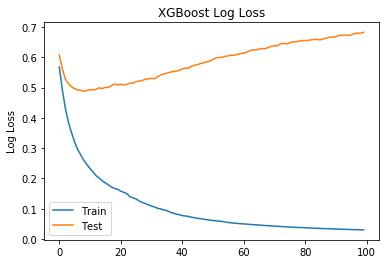

In [58]:
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

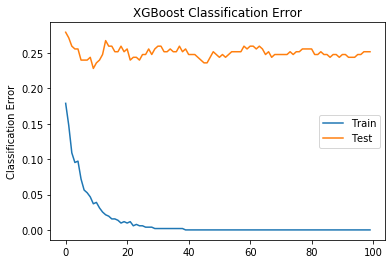

In [60]:
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [61]:
# fit model on training data and add early stopping to 10th epoch 
model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="logloss",eval_set=eval_set, verbose=True)
# make predictions for test data
predictions = model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-logloss:0.56785	validation_1-logloss:0.60720
[1]	validation_0-logloss:0.49181	validation_1-logloss:0.56171
[2]	validation_0-logloss:0.42989	validation_1-logloss:0.52669
[3]	validation_0-logloss:0.38381	validation_1-logloss:0.51372
[4]	validation_0-logloss:0.35061	validation_1-logloss:0.50175
[5]	validation_0-logloss:0.31914	validation_1-logloss:0.49618
[6]	validation_0-logloss:0.29530	validation_1-logloss:0.49222
[7]	validation_0-logloss:0.27715	validation_1-logloss:0.49175
[8]	validation_0-logloss:0.25933	validation_1-logloss:0.48701
[9]	validation_0-logloss:0.24552	validation_1-logloss:0.49024
[10]	validation_0-logloss:0.23251	validation_1-logloss:0.49282
[11]	validation_0-logloss:0.22093	validation_1-logloss:0.49205
[12]	validation_0-logloss:0.20865	validation_1-logloss:0.49443
[13]	validation_0-logloss:0.20103	validation_1-logloss:0.49906
[14]	validation_0-logloss:0.19166	validation_1-logloss:0.49688
[15]	validation_0-logloss:0.18495	validation_1-logloss:0.50045
[1

c:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,
c:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,
